### Spring 2025 ECG Analysis 

##### Modification: switched from rapidHRV to Systole for heart rate preprocessing & peak detection

In [33]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from scipy.stats import sem
from copy import copy as copy
import operator as operator

import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob

from scipy.signal import find_peaks

from scipy.signal import butter, filtfilt, find_peaks

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/var/folders/_k/84ry5gsj3bnd86w91nlcyck00000gr/T/ipykernel_30404/1149338489.py:13: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr # Pearson's correlation
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [34]:
import pathlib
from ecgdetectors import Detectors
import sys
sampleRate = 100
fs = sampleRate
detectors = Detectors(sampleRate)


In [42]:
mergedDFClean = pd.read_csv("mergedPhysioAndBehav_Jan2025.csv")
# remove Unamed columns
mergedDFClean = mergedDFClean.loc[:, ~mergedDFClean.columns.str.contains('^Unnamed')]
mergedDFClean['PART_trial'] = mergedDFClean['partNum'].astype(str) + '_' + mergedDFClean['session'].astype(str) + '_' + mergedDFClean['trials'].astype(str)
mergedDFClean = mergedDFClean.dropna()

In [43]:
#screamOn: flagging trials where scream is presented; infoOn: flagging trials where information is chosen

mergedDFClean.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'PART_trial'],
      dtype='object')

# separate signal by participant

# Preprocess data & detect r-peaks

### Use ECG Detectors (two average detector) for r-peak detection

In [245]:
###Uses two average detector for r peak detectino

def preprocess(delaydata):
    delayProcessed = pd.DataFrame()

    for participant in np.unique(delaydata['partNum']):
        dataPart = delaydata[delaydata['partNum'] == participant].copy()
        time =dataPart['time'].values
        signal = dataPart.EKG.values 
        r_peaks = detectors.pan_tompkins_detector(signal)
        peaks_mask = np.zeros_like(signal, dtype=bool)
        peaks_mask[r_peaks] = True

        dataPart['pEKG'] = signal #same as raw EKG value, changing the name for consistency purposes
        dataPart['peak'] = peaks_mask
        dataPart['peak_time'] = np.where(peaks_mask, time, np.nan)

        delayProcessed = pd.concat([delayProcessed, dataPart], ignore_index=True)

    return delayProcessed

# extract baseline using the start trial period (first 2 seconds)

In [67]:
def IBI_baseline(mergedDFClean):
    dataBaseline = mergedDFClean#.loc[(mergedDFClean['startTrial'] == 1)]
    dataBaseline0= preprocess(dataBaseline)

    ### create baseline IBI for each trial

    rows = []

    for participant in dataBaseline0['partNum'].unique():
        part_data = dataBaseline0[dataBaseline0['partNum'] == participant]
        for session in dataBaseline0['session'].unique():
            sess_data = part_data[part_data['session'] == session]
            
            for trial in sess_data['trials'].unique():
                trial_data = sess_data[sess_data['trials'] == trial]
                part_trial = trial_data['PART_trial'].iloc[0]
                
                peak_idxs = np.where(trial_data['peak'])[0]        
                
                
                if len(peak_idxs) < 2:
                    mean_ibi = np.nan

                else:
                    ibi_samples = np.diff(peak_idxs)
                    mean_ibi = ibi_samples.mean()/ sampleRate

                rows.append({
                    'participant': participant,
                    'session': session,
                    'trial': trial,
                    'baseline': mean_ibi,
                    'PART_trial': part_trial
                    
                })
            
    #return baseline_IBI
    baseline_IBI = pd.DataFrame(rows)

    
    return baseline_IBI


# Compute IBI intervals from before infochoice presentation till after stimulus presentation time

In [228]:
def compute_IBI (data,baseline_df):

    """
    Returns a DataFrame with one row per trial, containing:
      - participant, delay_time, PART_trial
      - IBIs: list of normalized IBIs (s)
      - time_norm: list of IBI timestamps relative to window start (s)
      - cue_norm, stim_norm: cue and stim onsets relative to window start (s)
    """
    rows = []

    for trials in data['PART_trial'].unique():
        trial_data = data[data['PART_trial']==trials]
        participant = trial_data['partNum'].iloc[0]
        delay = trial_data['delay_time'].iloc[0]

        #extract time point stimInfo or stimNoInfo is presented
        if 'stimInfoOnset' in trial_data.columns and trial_data['stimInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimInfoOnset']==1, 'time'].iloc[0]
        elif 'stimNoInfoOnset' in trial_data.columns and trial_data['stimNoInfoOnset'].eq(1).any():
            cueTime = trial_data.loc[trial_data['stimNoInfoOnset']==1, 'time'].iloc[0]
        else:
            cueTime = np.nan

        #extract time point scream or noScream is presented
        if 'screamOnset' in trial_data.columns and trial_data['screamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['screamOnset']==1,'time'].iloc[0]
        elif 'noScreamOnset' in trial_data.columns and trial_data['noScreamOnset'].eq(1).any():
            stimTime = trial_data.loc[trial_data['noScreamOnset']==1,'time'].iloc[0]    
        else:
            stimTime = np.nan

        #define start and end time of where ibi values will be extracted
        pre_window = 4.0 #adding 4 sec before infocue onset
        post_window = 4.0 #adding 4 sec after outcome stimulus presentation
        start = cueTime - pre_window
        end = stimTime + post_window

        
        # restrict to peaks in that window
        peak_times = trial_data.loc[trial_data['peak']==1, 'time'].values
        in_window = peak_times[(peak_times >= start) & (peak_times <= end)]
        if len(in_window) < 2:
            continue
        
        #compute raw and normalized ibis
        ibis      = np.diff(in_window)
        ibi_times = (in_window[:-1] + in_window[1:]) / 2

        # —— normalize time to window start —— 
        t_norm     = (ibi_times - start).tolist()
        cue_norm   = cueTime   - start
        stim_norm  = stimTime  - start

        base       = baseline_df.loc[
                         baseline_df['PART_trial']==trials,'baseline'
                     ].iloc[0]
        ibis_norm  = (ibis - base).tolist()

        
        # get this trial’s delay_time (or whatever column you have)
        delay = trial_data['delay_time'].iloc[0]

        
        # collect one row per IBI
        rows.append({
            'participant': participant,
            'delay_time':  delay,
            'PART_trial':  trials,
            'IBIs':        ibis_norm,
            'time_norm':   t_norm,
            'cue_norm':    cue_norm,
            'stim_norm':   stim_norm
        })
        
    return pd.DataFrame(rows)

        
    

In [ ]:
def part_avg_IBI(df):
    """
    Takes the trial-level DataFrame (output of compute_trial_ibis)
    and returns one row per participant x delay_time, with:
      - time_norm: common sorted time grid
      - mean_IBI:  mean of IBIs at each time point
      - cue_norm, stim_norm (same across trials)
    """
    summary_rows = []

    for (participant, delay), group in df.groupby(['participant','delay_time']):
        # 1) build the union of all time points
        all_t = sorted({t for times in group['time_norm'] for t in times})

        # 2) at each t, average the IBIs across trials
        mean_ibi = []
        for t in all_t:
            vals = [
                ibi
                for times, ibis in zip(group['time_norm'], group['IBIs'])
                for (tt, ibi) in zip(times, ibis)
                if np.isclose(tt, t)
            ]
            mean_ibi.append(np.mean(vals) if vals else np.nan)

        # 3) cue/stim markers (identical across trials)
        cue  = group['cue_norm'].iloc[0]
        stim = group['stim_norm'].iloc[0]

        summary_rows.append({
            'participant': participant,
            'delay_time':  delay,
            'time_norm':   all_t,
            'mean_IBI':    mean_ibi,
            'cue_norm':    cue,
            'stim_norm':   stim
        })

    return pd.DataFrame(summary_rows)    

In [160]:
def plot_by_delay(summary_df):
    """
    For each unique delay_time in summary_df, open a new figure and plot
    each participant's mean_IBI curve (time_norm vs. mean_IBI),
    plus vertical lines at cue_norm and stim_norm.
    """
    for delay, group in summary_df.groupby('delay_time'):
        plt.figure()
        for _, row in group.iterrows():
            # plot this participant's curve
            plt.plot(
                row['time_norm'],
                row['mean_IBI'],
                '-o',
                label=f"P{row['participant']}"
            )
        # event markers (they're the same across participants at a given delay)
        cue = group['cue_norm'].iloc[0]
        stim = group['stim_norm'].iloc[0]
        plt.axvline(cue,  color='green', linestyle='--', label='Info cue')
        plt.axvline(stim, color='red',   linestyle='--', label='Stim onset')

        plt.title(f"Mean normalized IBI — Delay {delay}s")
        plt.xlabel('Time since window start (s)')
        plt.ylabel('Normalized IBI (s)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [165]:
import numpy as np
import matplotlib.pyplot as plt

def average_ibis_over_trials(trial_df, n_points=200):
    """
    trial_df: output of compute_trial_ibis, filtered to one (participant, delay).
      must have columns 'time_norm' (list) and 'IBIs' (list) per row.
    n_points: number of samples in the common time grid.
    """
    # 1) determine the common window length
    t_max = max(max(times) for times in trial_df['time_norm'])
    t_grid = np.linspace(0, t_max, n_points)

    # 2) build an array (#trials x n_points) of interpolated IBIs
    ibi_matrix = []
    for _, row in trial_df.iterrows():
        times = row['time_norm']
        ibis  = row['IBIs']
        # interpolate; out‑of‑bounds becomes NaN
        interp_ibi = np.interp(
            t_grid,
            times,
            ibis,
            left=np.nan,
            right=np.nan
        )
        ibi_matrix.append(interp_ibi)
    ibi_matrix = np.vstack(ibi_matrix)  # shape = (n_trials, n_points)

    # 3) mean across trials (skip NaNs)
    mean_ibi   = np.nanmean(ibi_matrix, axis=0)

    # 4) pick your cue/stim markers (they’re identical across trials)
    cue   = trial_df['cue_norm'].iloc[0]
    stim  = trial_df['stim_norm'].iloc[0]

    return t_grid, mean_ibi, cue, stim


def plot_average_for_delay(trial_df, participant, delay_time):
    # filter to just that (participant, delay)
    sel = trial_df[
        (trial_df['participant']==participant) &
        (trial_df['delay_time']==delay_time)
    ]
    t_grid, mean_ibi, cue, stim = average_ibis_over_trials(sel)

    plt.figure()
    plt.plot(t_grid, mean_ibi, '-o', label=f"P{participant}")
    plt.axvline(cue,  color='green', linestyle='--', label='Info cue')
    plt.axvline(stim, color='red',   linestyle='--', label='Stim onset')
    plt.title(f"Mean normalized IBI — P{participant}, Delay {delay_time}s")
    plt.xlabel('Time since window start (s)')
    plt.ylabel('Normalized IBI (s)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
### returns all IBI by delay time
def stimInfo_IBI(data):
    
    data['peaks'] = [0]*len(data)
    test_IBI_by_delay = {}

    for trials in data['PART_trial'].unique():
        trial_data = data[data['PART_trial']==trials]
        r_peaks = detectors.two_average_detector(trial_data['pEKG'].values)
        trial_data = trial_data.reset_index()
        trial_data.loc[trial_data.index.isin(r_peaks), 'peaks'] = 1

        peaks_data = trial_data[trial_data['peaks']==1]

        # extract time point stimInfo is presented
        infoStimOnset = trial_data.loc[trial_data['stimInfoOnset'] == 1, 'time'].values
        if(len(infoStimOnset)>1):
            infoStimOnset = infoStimOnset[0]

        # Mark test_IBI values before and after infoStimOnset
        before_stim = []
        after_stim = []
        baseline_data = baseline_IBI[baseline_IBI['PART_trial'] == trials]['baseline'].values
        
        for time in peaks_data['time']:
            if time < infoStimOnset:
                before_stim.append(peaks_data.loc[peaks_data['time']==time,'time'])
            else:
                after_stim.append(peaks_data.loc[peaks_data['time']==time,'time'])
        
        before_IBI = np.diff(np.ravel(np.array([entry for entry in before_stim])))
        before_IBI = [val - baseline_data for val in before_IBI]
        
        
        after_IBI = np.diff(np.ravel(np.array([entry for entry in after_stim])))
        after_IBI = [val - baseline_data for val in after_IBI]

        # concatenate before_stim, mark, and after_stim
        mark = ['mark']
        test_IBI = before_IBI + mark + after_IBI

        delay_time = trial_data['delays'].unique()[0]
        if delay_time not in test_IBI_by_delay:
            test_IBI_by_delay[delay_time] = {}

        # If there are no values after infoStimOnset, set flag to False
        flag = bool(after_stim)

        # add infoStimOnset, test_IBI, and the marked values to test_IBI_by_delay
        test_IBI_by_delay[delay_time][trials] = {
            'before_IBI': before_IBI,
            'after_IBI': after_IBI,
        }

    return test_IBI_by_delay



In [ ]:
#calculate average IBI for each delay and returns final IBI + error bar to be plotted

def stimInfo_avgIBI(data):
    average_values_before_list = []
    #standard_error_before_list = []
    average_values_after_list = []
    standard_error_list = []

    for delay_time in data:
        # Access the trial data for the current delay time
        delay_data = data[delay_time]        
        
        min_length_before = max(2,min(len(delay_data[part_trial]['before_IBI']) for part_trial in delay_data.keys()))
        min_length_after = max(2,min(len(delay_data[part_trial]['after_IBI']) for part_trial in delay_data.keys()))
        
        # Calculate the average value in each position
        average_values_before = np.zeros(min_length_before)
        average_values_after = np.zeros(min_length_after)
        
        num_nonempty_arrays_before = 0  # Counter for non-empty arrays
        num_nonempty_arrays_after = 0
        
        values_list = []

        for part_trial in delay_data:
            values_before = np.array(delay_data[part_trial]['before_IBI'][:min_length_before], dtype='float64')
            values_before = np.ndarray.flatten(values_before)
            values_after = np.array(delay_data[part_trial]['after_IBI'][:min_length_after], dtype='float64')
            values_after = np.ndarray.flatten(values_after)
            
            
            values = np.concatenate((values_before,values_after))
            values = np.ndarray.flatten(values)
            values_list.append(values)
            
            # Skip if the array is empty
            if len(values_before) == 0 or len(values_after) == 0:
                continue

            average_values_before += values_before
            num_nonempty_arrays_before +=1
            average_values_after += values_after
            num_nonempty_arrays_after += 1
    
        values_size = max(len(array) for array in values_list)
    
        for i in range(len(values_list)):
            if len(values_list[i]) != values_size:
                num = values_size-len(values_list[i])
                values_list[i] = np.append(values_list[i],[np.nan]*num)

    
        # Calculate the mean and standard error only if there are non-empty arrays
        if num_nonempty_arrays_before > 0:
            average_values_before /= num_nonempty_arrays_before
            #standard_error_before = sem(average_values_before)
        #else:
            #standard_error_before = np.nan

        average_values_before_list.append(average_values_before)
        #standard_error_before_list.append(standard_error_before)
        
        if num_nonempty_arrays_after > 0:
            average_values_after /= num_nonempty_arrays_after
            average_values_after_list.append(average_values_after)
            #standard_error_after = sem(average_values_after)
        #else:
            #standard_error_after = np.nan
        ''' 
        #combine before and after to calculate standard error
    
        average_values = np.concatenate((average_values_before,average_values_after))
        if  num_nonempty_arrays_before+num_nonempty_arrays_after>0:
            standard_error = sem(average_values)
        else:
            standard_error = np.nan

        
        standard_error_list.append(standard_error)
    '''
    
    #********#*#*#***************#calcualte standard error 
        transposed_arrays = np.array(values_list).T

        standard_errors = []

        # Calculate the standard error for each entry
        for entry in transposed_arrays:
            std_error = scipy.stats.sem(entry, nan_policy='omit')
            standard_errors.append(std_error)
        standard_error_list.append(standard_errors)

    #********#*#*#***************#
        
    average_values_df = pd.DataFrame({
        'Delay Time': data.keys(),
        'Average Values Before': average_values_before_list,
        #'Standard Error Before': standard_error_before_list,
        'Average Values After': average_values_after_list,
        'Standard Error': standard_error_list,
        #'stimInfoOnset' : sti
    })

    return average_values_df


In [ ]:
def plot_whole_IBI(info_scream_IBI,info_noScream_IBI,delay):
    

    scream_before = info_scream_IBI.loc[info_scream_IBI['Delay Time'] == delay, 'Average Values Before']
    scream_before.index = [0]
    scream_after = info_scream_IBI.loc[info_scream_IBI['Delay Time'] == delay, 'Average Values After']
    scream_after.index = [0]


    noScream_before = info_noScream_IBI.loc[info_noScream_IBI['Delay Time'] == delay, 'Average Values Before']
    noScream_before.index = [0]

    noScream_after = info_noScream_IBI.loc[info_noScream_IBI['Delay Time'] == delay, 'Average Values After']
    noScream_after.index = [0]



    # Concatenate the "before" and "after" values into a single array
    combined_noScream = np.concatenate([np.concatenate(noScream_before), np.concatenate(noScream_after)])
    combined_scream = np.concatenate([np.concatenate(scream_before), np.concatenate(scream_after)])

    # Plotting
    #fig, ax = plt.subplots()
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1)



    # Plot the combined values as a single line
    #plt.plot(combined_scream, label='info scream')
    #plt.plot(combined_noScream, label='info no scream')


    # Calculate the index where the "after" values start
    noScream_after_start_index = len(noScream_before[0])
    scream_after_start_index = len(scream_before[0])
    # Add a vertical line at the separation point
    
    #ax.axvline(x=noScream_after_start_index, linestyle='--', label = 'infoStimOnset',color='red')
    
    #calcualte and plot error bar
    info_no_scream_standard_error = np.array(info_noScream_IBI['Standard Error'][info_noScream_IBI['Delay Time'] == delay].values)[0]
    
    info_scream_standard_error = np.array(info_scream_IBI['Standard Error'][info_scream_IBI['Delay Time'] == delay].values)[0]
    
        
    #ensure standard error and average values are the same length
    if len(info_scream_standard_error) > (len(combined_scream)):
        info_scream_standard_error = info_scream_standard_error[:len(combined_scream)]
    else:
        combined_scream = combined_scream[:len(info_scream_standard_error)]
        
    if len(info_no_scream_standard_error) > (len(combined_noScream)):
        info_no_scream_standard_error = info_no_scream_standard_error[:len(combined_noScream)]
    else:
        combined_noScream = combined_noScream[:len(info_no_scream_standard_error)]
    
    # if delay == 5:
    #     x_scream_values = [-2,-1,0,1,2]
    #     x_noScream_values = [-2,-1,0,1,2]
    # elif delay == 2:
    #     x_scream_values =[-2,-1,0,1]
    #     x_noScream_values =[-2,-1,0,1]
    # elif delay == 10:
    #     x_scream_values =[-2,-1,0,1,2,3,4,5,6,7]
    #     x_noScream_values =[-2,-1,0,1,2,3,4,5,6,7]
    # elif delay == 20:
    #     x_scream_values =[-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,]
    #     x_noScream_values =[-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
    # else:

    x_scream_values = range(-2, len(combined_scream)-2)
    x_noScream_values = range(-2, len(combined_noScream)-2) 
    

    colorScream = '#FD7E84'
    colorNoScream = "#8DB38B"


    plt.errorbar(x_scream_values, combined_scream, yerr=info_scream_standard_error, label='Scream',color=colorScream)    
    ax.fill_between(x_scream_values, combined_scream - info_scream_standard_error, combined_scream + info_scream_standard_error, color=colorScream, alpha=0.2)
    
    plt.errorbar(x_noScream_values, combined_noScream, yerr=info_no_scream_standard_error,label='No Scream',color=colorNoScream)
    ax.fill_between(x_noScream_values, combined_noScream - info_no_scream_standard_error, combined_noScream + info_no_scream_standard_error, color=colorNoScream, alpha=0.2)

    
    
    ax.axvline(0, linestyle='--', label = 'Info Cue',color='#0B3954')
    
    #print(info_scream_standard_error)
    #print(info_no_scream_standard_error)

    
    plt.scatter(x_scream_values, combined_scream,color=colorScream)
    plt.scatter(x_noScream_values, combined_noScream,color=colorNoScream)

    # Set labels and title
    ax.set_xlabel('Beats', fontsize=25)
    ax.set_ylabel('Normalized IBI', fontsize=25)

    if len(x_scream_values)>25 :
        x_scream_values = x_scream_values[::2]
        x_noScream_values = x_noScream_values[::2]
                
    if len(x_scream_values) > len(x_noScream_values):
        
        print(x_scream_values)
        print(x_noScream_values)

        plt.xticks(x_scream_values, fontsize=20)
    else:
        print(x_scream_values)
        print(x_noScream_values)
        plt.xticks(x_noScream_values, fontsize=20)

    plt.tick_params(axis='x', labelsize=25)

    plt.tick_params(axis='y', labelsize=25)
    sns.set_style("white")
    sns.despine()
    #ax.set_aspect(1.0)

    ax.set_title("{} second delay".format(delay))

    # Add a legend
    ax.legend(fontsize=25,frameon=False)

    

    # Show the plot
    #plt.show()


In [85]:
baseline_IBI_stimInfo_scream= IBI_baseline(mergedDFClean.loc[(mergedDFClean['startTrial'] == 1)& (mergedDFClean['screamOn'] == 1) & (mergedDFClean['infoOn'] == 1) ])

In [69]:
baseline_IBI

,participant,session,trial,baseline,PART_trial
0,44,0,2,0.583333,44_0_2
1,44,0,4,0.606667,44_0_4
2,44,0,13,0.736667,44_0_13
3,44,0,16,0.715000,44_0_16
4,44,1,4,0.693333,44_1_4
...,...,...,...,...,...
1363,132,3,12,0.780000,132_3_12
1364,132,3,15,0.875000,132_3_15
1365,132,4,6,0.845000,132_4_6
1366,132,4,11,0.850000,132_4_11


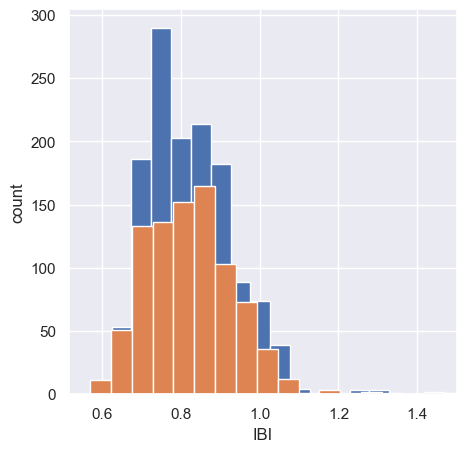

In [71]:
screamInfo_IBI= IBI_baseline(mergedDFClean.loc[ (mergedDFClean['screamOn'] == 0) & (mergedDFClean['infoOn'] == 1) ])
noScreamInfo_IBI= IBI_baseline(mergedDFClean.loc[ (mergedDFClean['screamOn'] == 0) & (mergedDFClean['infoOn'] == 0) ])

plt.hist(screamInfo_IBI.baseline.values, bins)

plt.hist(noScreamInfo_IBI.baseline.values,bins)
plt.xlim(right = 1.5)
plt.xlabel('IBI')
plt.ylabel('count')
plt.show()


In [72]:
screamInfo_IBI

,participant,session,trial,baseline,PART_trial
0,44,0,0,0.693000,44_0_0
1,44,0,1,0.688077,44_0_1
2,44,0,5,0.694103,44_0_5
3,44,0,8,0.706667,44_0_8
4,44,0,9,0.695200,44_0_9
...,...,...,...,...,...
1346,132,4,17,0.787826,132_4_17
1347,132,4,19,0.824626,132_4_19
1348,132,5,2,0.845714,132_5_2
1349,132,5,6,0.749565,132_5_6


In [73]:
noScreamInfo_IBI

,participant,session,trial,baseline,PART_trial
0,44,0,11,0.697436,44_0_11
1,44,0,18,0.673462,44_0_18
2,44,1,5,0.707917,44_1_5
3,44,1,6,0.723846,44_1_6
4,44,1,7,0.723333,44_1_7
...,...,...,...,...,...
881,132,4,3,0.869091,132_4_3
882,132,4,4,0.864000,132_4_4
883,132,4,10,0.818182,132_4_10
884,132,4,13,0.813182,132_4_13


In [74]:
mergedDFClean.columns

Index(['PART_x', 'EKG', 'EDA', 'startBlock', 'startTrial', 'infoChoice',
       'stimInfo', 'stimNoInfo', 'scream', 'noScream', 'endTrial',
       'startTrialOnset', 'screamOnset', 'noScreamOnset', 'infoChoiceOnset',
       'stimInfoOnset', 'stimNoInfoOnset', 'startBlockOnset', 'timePart',
       'time', 'trials', 'zEDA', 'delays', 'delaysRaw', 'session', 'partNum',
       'PART_y', 'delay_time', 'choice_keys', 'prob', 'screamOn', 'infoOn',
       'filename', 'PART_trial'],
      dtype='object')

In [202]:
processed_all = preprocess(mergedDFClean)
# Filter the trials where 'scream' column is 1
trialNum_scream = processed_all.loc[processed_all['scream'] == 1, 'PART_trial'].unique()
trialNum_noScream = processed_all.loc[processed_all['noScream'] == 1, 'PART_trial'].unique()


# Filter the DataFrame based on each unique trial number and 'stimInfo' column
#this is wrong because it will also include trials where there's no info but during infochoice time
processed_stimInfo_scream = processed_all[(processed_all['PART_trial'].isin(trialNum_scream)) & (processed_all['stimInfo'] == 1)] 
processed_stimInfo_noScream = processed_all[(processed_all['PART_trial'].isin(trialNum_noScream)) & (processed_all['stimInfo'] == 1) ]

# Filter the trials in scream and no scream conditions, where 'stimInfo' is 1
trialNum_screamInfo = processed_stimInfo_scream['PART_trial'].unique()
trialNum_noScreamInfo = processed_stimInfo_noScream['PART_trial'].unique()

In [88]:
processed_all

,PART_x,EKG,EDA,startBlock,startTrial,infoChoice,stimInfo,stimNoInfo,scream,noScream,...,delay_time,choice_keys,prob,screamOn,infoOn,filename,PART_trial,pEKG,peak,peak_time
0,P044_Aversive,-0.126495,3.59192,0,1,0,0,0,0,0,...,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_0,-0.126495,False,NaN
1,P044_Aversive,-0.215912,3.59039,0,1,0,0,0,0,0,...,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_0,-0.215912,False,NaN
2,P044_Aversive,-0.307312,3.59192,0,1,0,0,0,0,0,...,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_0,-0.307312,False,NaN
3,P044_Aversive,-0.311432,3.59039,0,1,0,0,0,0,0,...,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_0,-0.311432,False,NaN
4,P044_Aversive,-0.287170,3.59192,0,1,0,0,0,0,0,...,20.0,j,5.0,0.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_0,-0.287170,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12708414,P132_Aversive,-0.005310,4.98199,0,0,0,0,0,0,0,...,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,132_5_19,-0.005310,False,NaN
12708415,P132_Aversive,-0.020203,4.98810,0,0,0,0,0,0,0,...,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,132_5_19,-0.020203,False,NaN
12708416,P132_Aversive,-0.015320,4.98352,0,0,0,0,0,0,0,...,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,132_5_19,-0.015320,False,NaN
12708417,P132_Aversive,-0.010315,4.98199,0,0,0,0,0,0,0,...,10.0,j,4.0,1.0,0.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,132_5_19,-0.010315,False,NaN


In [203]:

# extract data that includes both infoChoice and stimInfo
processed_stimInfo_scream = processed_all[(processed_all['screamOn']==1)&(processed_all['infoOn']==1)] 
processed_stimInfo_noScream = processed_all[(processed_all['screamOn']==0) & (processed_all['infoOn']==1)]

In [204]:
processed_all.loc[(processed_all['partNum']==58)].trials.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [205]:
processed_stimInfo_scream['screamOnset'].unique()

array([False,  True])

In [206]:
processed_stimInfo_scream

,PART_x,EKG,EDA,startBlock,startTrial,infoChoice,stimInfo,stimNoInfo,scream,noScream,...,delay_time,choice_keys,prob,screamOn,infoOn,filename,PART_trial,pEKG,peak,peak_time
4676,P044_Aversive,-0.227814,3.25012,0,1,0,0,0,0,0,...,5.0,j,4.0,1.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_2,-0.227814,False,NaN
4677,P044_Aversive,-0.217743,3.25317,0,1,0,0,0,0,0,...,5.0,j,4.0,1.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_2,-0.217743,False,NaN
4678,P044_Aversive,-0.161743,3.25012,0,1,0,0,0,0,0,...,5.0,j,4.0,1.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_2,-0.161743,False,NaN
4679,P044_Aversive,-0.173187,3.25317,0,1,0,0,0,0,0,...,5.0,j,4.0,1.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_2,-0.173187,False,NaN
4680,P044_Aversive,-0.101776,3.25317,0,1,0,0,0,0,0,...,5.0,j,4.0,1.0,1.0,AV_P044_timeline_Blocks_macVer_2023-11-17_14h3...,44_0_2,-0.101776,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12665841,P132_Aversive,-0.201111,5.46112,0,0,0,0,0,0,0,...,20.0,l,4.0,1.0,1.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,132_5_3,-0.201111,False,NaN
12665842,P132_Aversive,-0.184204,5.46570,0,0,0,0,0,0,0,...,20.0,l,4.0,1.0,1.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,132_5_3,-0.184204,False,NaN
12665843,P132_Aversive,-0.165955,5.46265,0,0,0,0,0,0,0,...,20.0,l,4.0,1.0,1.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,132_5_3,-0.165955,False,NaN
12665844,P132_Aversive,-0.161865,5.46112,0,0,0,0,0,0,0,...,20.0,l,4.0,1.0,1.0,AV_P132_timeline_Blocks_randKeyCue_macVer_2025...,132_5_3,-0.161865,False,NaN


In [207]:

def plot_ecg_with_peaks(df, trial_id, signal_col='EKG'):
    """
    Plot raw ECG (or filtered EKG) for one trial, with R‑peaks marked.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Your full dataset, must contain 'time', signal_col, 'peak', 'PART_trial'.
    trial_id : str
        The PART_trial string to plot (e.g. "44_0_2").
    signal_col : str, optional
        Column name for the ECG trace ('EKG' or 'pEKG'), by default 'EKG'.
    """
    # select the trial
    d = df[df['PART_trial'] == trial_id]
    times  = d['time'].values
    signal = d[signal_col].values
    
    # find peaks
    peak_mask  = d['peak'].astype(bool)
    peak_times = times[peak_mask]
    peak_vals  = signal[peak_mask]
    
    # plot
    plt.figure(figsize=(12,4))
    plt.plot(times, signal, label=signal_col)
    plt.scatter(peak_times, peak_vals,
                color='red', marker='x', s=50,
                label='R‑peaks')
    
    plt.xlabel('Time (s)')
    plt.ylabel('ECG amplitude')
    plt.title(f'ECG & R‑peaks — Trial {trial_id}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [243]:
processed_stimInfo_scream['PART_trial'].unique()

array(['44_0_2', '44_0_4', '44_0_13', ..., '132_4_6', '132_4_11',
       '132_5_3'], dtype=object)

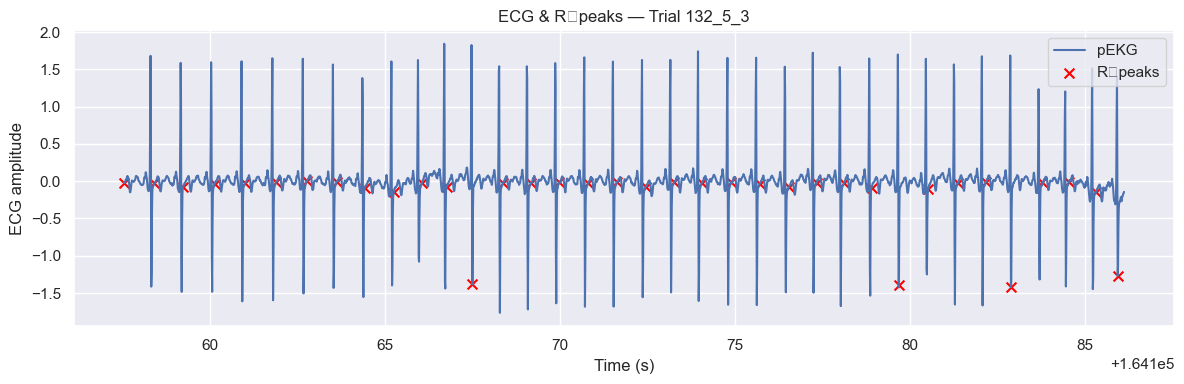

In [244]:
plot_ecg_with_peaks(processed_stimInfo_scream, '132_5_3', signal_col='pEKG')


In [229]:
info_scream_IBI = compute_IBI(processed_stimInfo_scream,baseline_IBI_stimInfo_scream)

In [210]:
info_scream_IBI

,participant,delay_time,PART_trial,IBIs,time_norm,cue_norm,stim_norm
0,44,5.0,44_0_2,"[0.1166666666667121, 0.10666666666660751, 0.10...","[1.509999999999991, 2.205000000000041, 2.89499...",4.0,9.01
1,44,10.0,44_0_4,"[0.09333333333337879, 0.07333333333328329, 0.0...","[0.8899999999999864, 1.5799999999999272, 2.259...",4.0,14.03
2,44,5.0,44_0_13,"[0.04333333333330602, 0.003333333333342403, -0...","[0.9599999999999227, 1.7199999999999136, 2.449...",4.0,9.01
3,44,2.0,44_0_16,"[-0.0249999999999454, 0.05499999999998184, -0....","[1.4650000000000318, 2.19500000000005, 2.90500...",4.0,6.01
4,44,2.0,44_1_4,"[-0.00333333333350605, -0.023333333333260486, ...","[0.8150000000000546, 1.4949999999998909, 2.164...",4.0,6.01
...,...,...,...,...,...,...,...
1355,132,20.0,132_3_12,"[-1.1641798636219391e-12, -0.04999999998952265...","[0.6099999999860302, 1.3649999999906868, 2.145...",4.0,24.02
1356,132,10.0,132_3_15,"[-0.005000000004656613, 0.005000000004656613, ...","[1.1750000000174623, 2.0500000000174623, 2.945...",4.0,14.01
1357,132,20.0,132_4_6,"[-0.014999999983701828, 0.014999999986030188, ...","[1.014999999984866, 1.8599999999860302, 2.7399...",4.0,24.03
1358,132,5.0,132_4_11,"[-0.010000000003492437, -0.040000000002328284,...","[0.9500000000116415, 1.7749999999941792, 2.614...",4.0,9.02


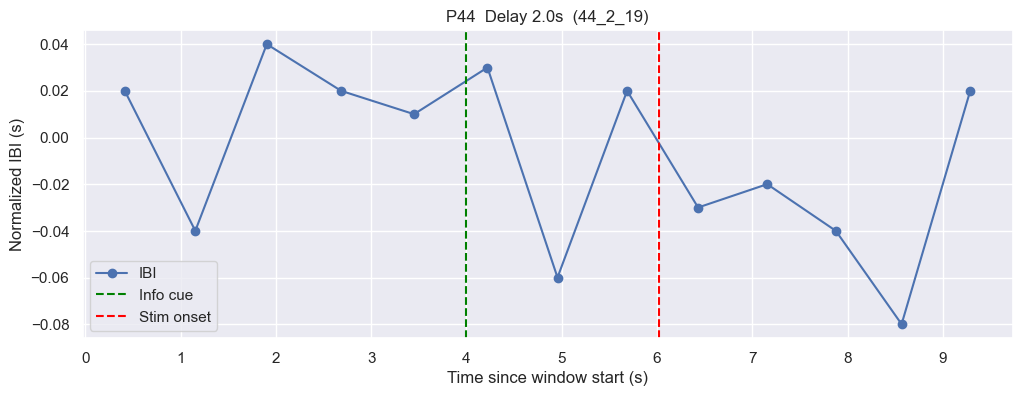

In [235]:
import matplotlib.pyplot as plt

def plot_ibi_row(row):
    """
    row: a single pandas Series with fields
      IBIs      – list of normalized IBI values
      time_norm – list of timestamps (s), normalized so t=0 at window start
      cue_norm  – scalar, info‑cue time (s) after window start
      stim_norm – scalar, stim‑onset time (s) after window start
      participant, delay_time, PART_trial – for labeling
    """
    times = row['time_norm']
    ibis  = row['IBIs']
    cue   = row['cue_norm']
    stim  = row['stim_norm']

    plt.figure(figsize=(12,4))
    plt.plot(times, ibis, '-o', label='IBI')
    plt.axvline(cue,  color='green', linestyle='--', label='Info cue')
    plt.axvline(stim, color='red',   linestyle='--', label='Stim onset')
    plt.title(
        f"P{row['participant']}  Delay {row['delay_time']}s  ({row['PART_trial']})"
    )
    plt.xlabel('Time since window start (s)')
    plt.ylabel('Normalized IBI (s)')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(int(min(times)), int(max(times)) + 1, 1))

    plt.show()


# Example: plot the very first row
plot_ibi_row(info_scream_IBI.iloc[10])


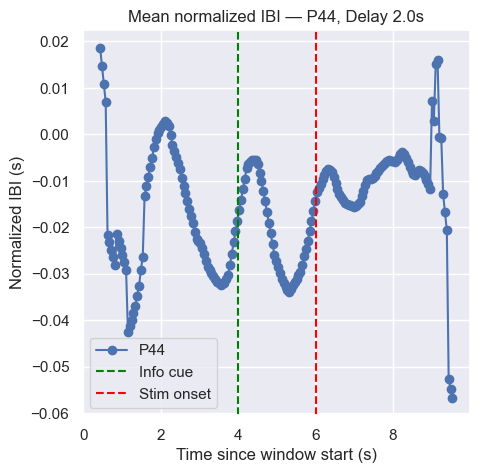

In [232]:
plot_average_for_delay(info_scream_IBI, participant=44, delay_time=2.0)


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


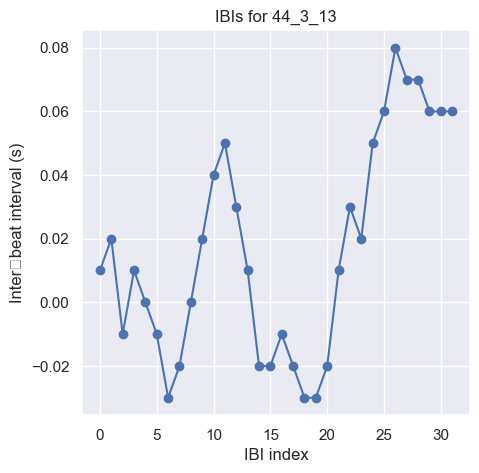

In [142]:
import matplotlib.pyplot as plt

# 1) pick your participant
participant_id = '44'  # or whatever ID you’re interested in


# otherwise, filter by the PART_trial prefix:
df_p = info_scream_IBI[(info_scream_IBI['PART_trial'].str.startswith(participant_id + '_'))&(info_scream_IBI['delay_time']==20)]

# 2) (only if you’re still in list‐per‐trial form) explode:
# df_p = df_p.explode('IBI').reset_index(drop=True)

# 3) make a simple line plot of IBI vs. trial index

for _, row in df_p.iterrows():
    part_trial = row['PART_trial']
    ibis       = row['IBI']   # this is your list of values

    plt.figure()
    plt.plot(range(len(ibis)), ibis, marker='o')
    plt.title(f'IBIs for {part_trial}')
    plt.xlabel('IBI index')
    plt.ylabel('Inter‑beat interval (s)')
    plt.grid(True)
    plt.show()

In [143]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

info_scream_IBI = stimInfo_avgIBI(stimInfo_IBI(processed_stimInfo_scream))
info_noScream_IBI = stimInfo_avgIBI(stimInfo_IBI(processed_stimInfo_noScream))

warnings.filterwarnings("default")

NameError: name 'stimInfo_avgIBI' is not defined

range(-2, 2)
range(-2, 2)


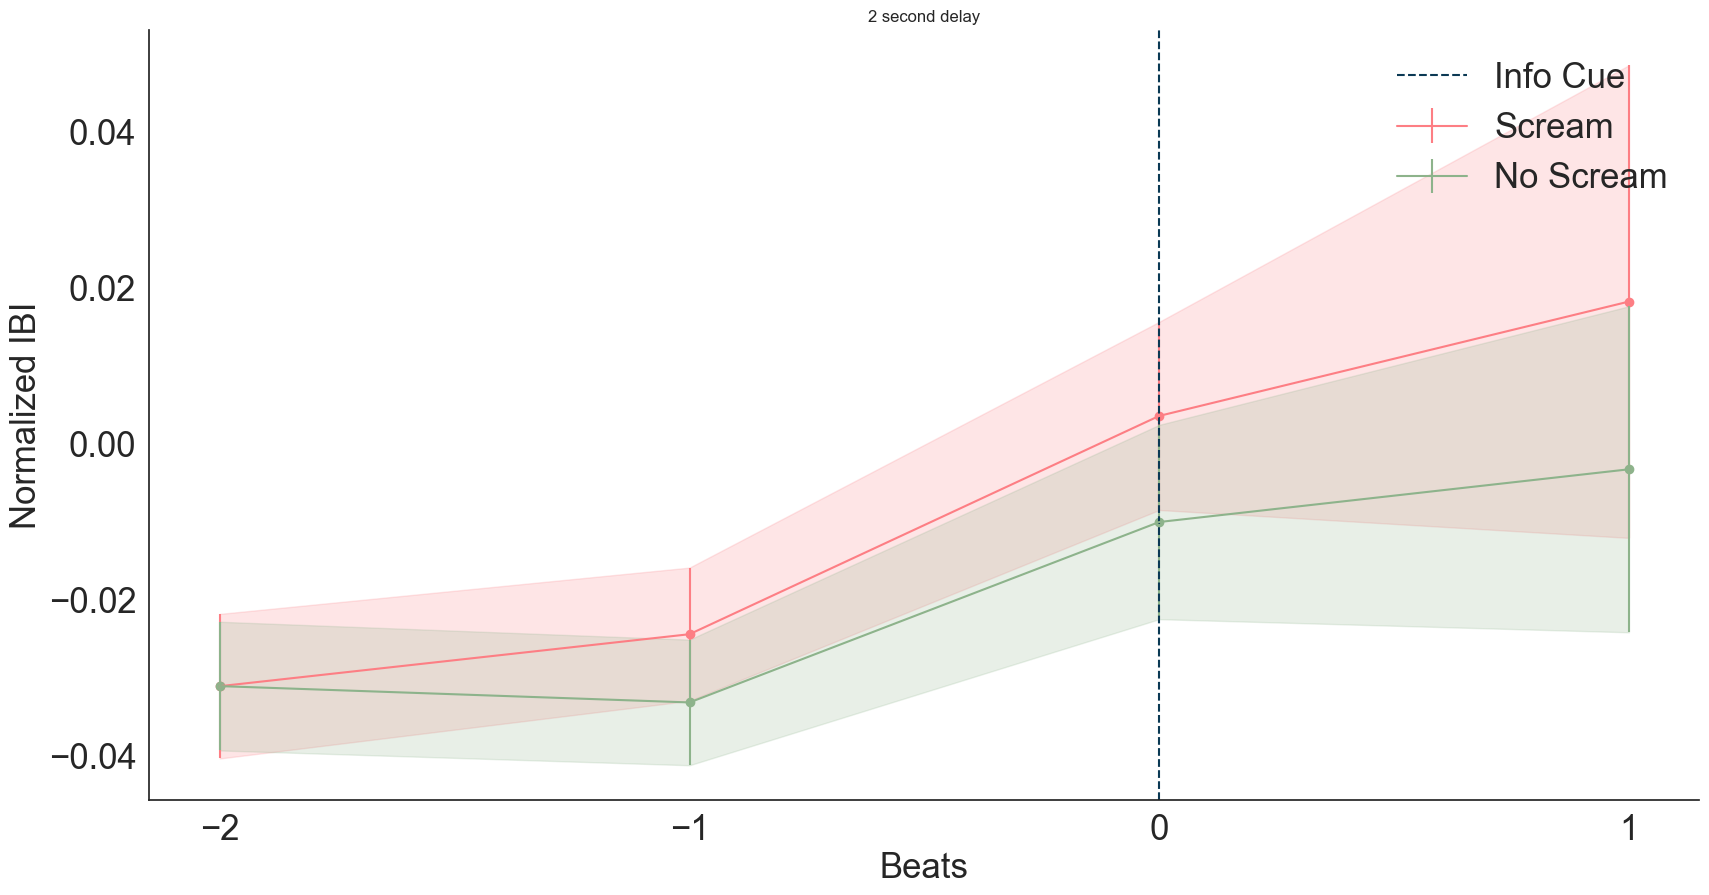

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,2)


range(-2, 5)
range(-2, 5)


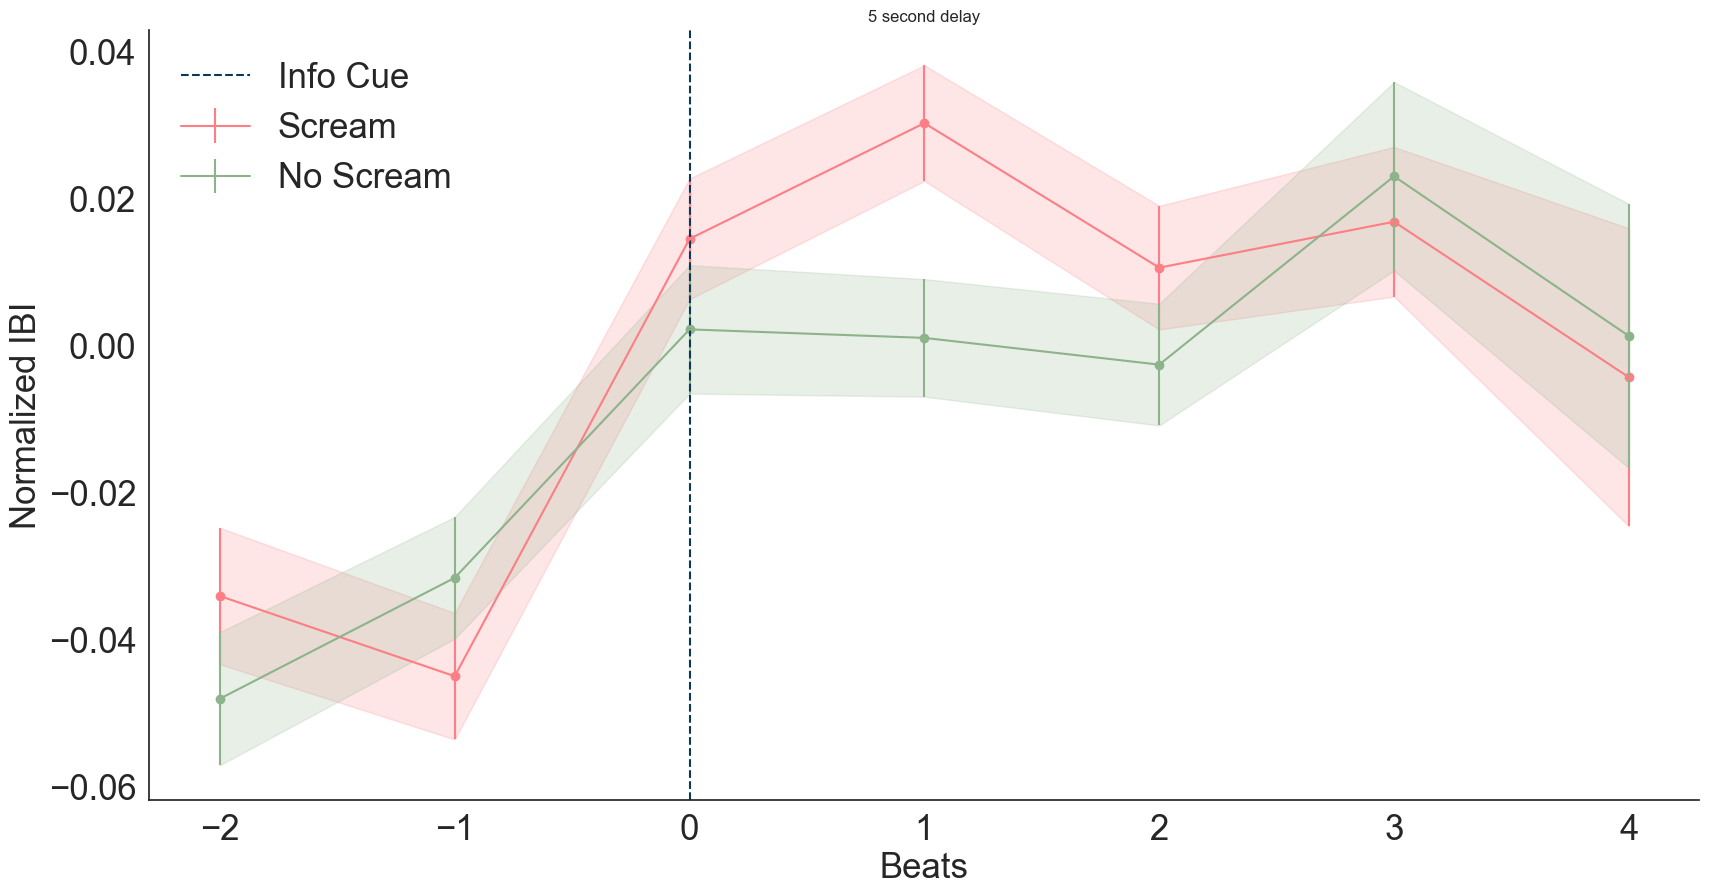

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,5)


range(-2, 11)
range(-2, 12)


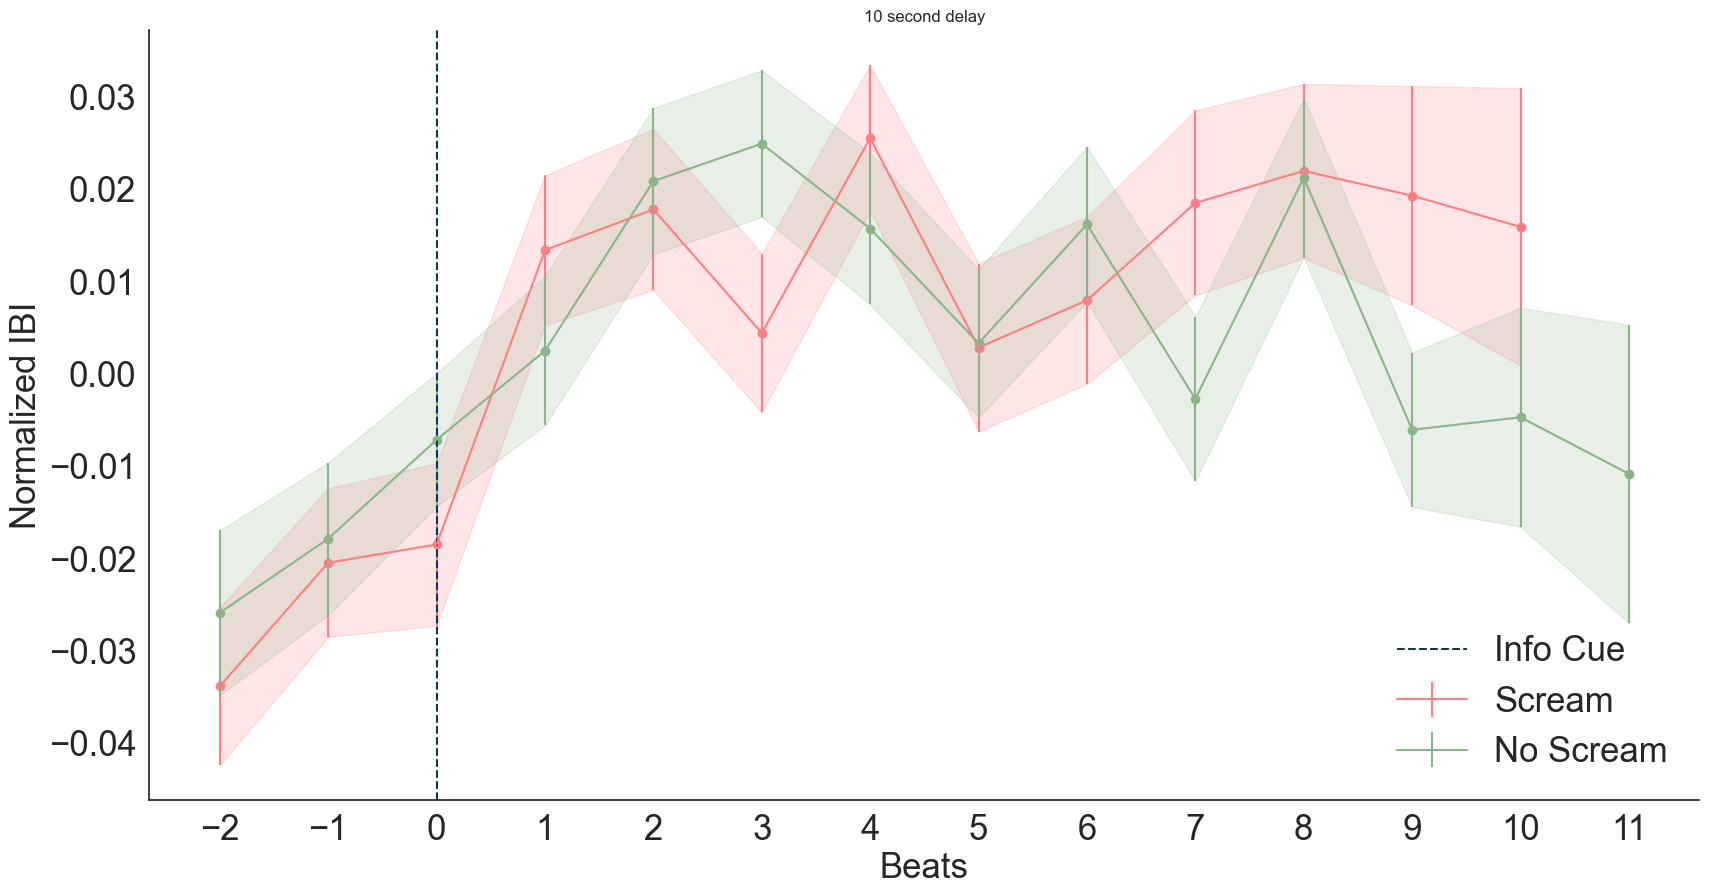

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,10)


range(-2, 25, 2)
range(-2, 26, 2)


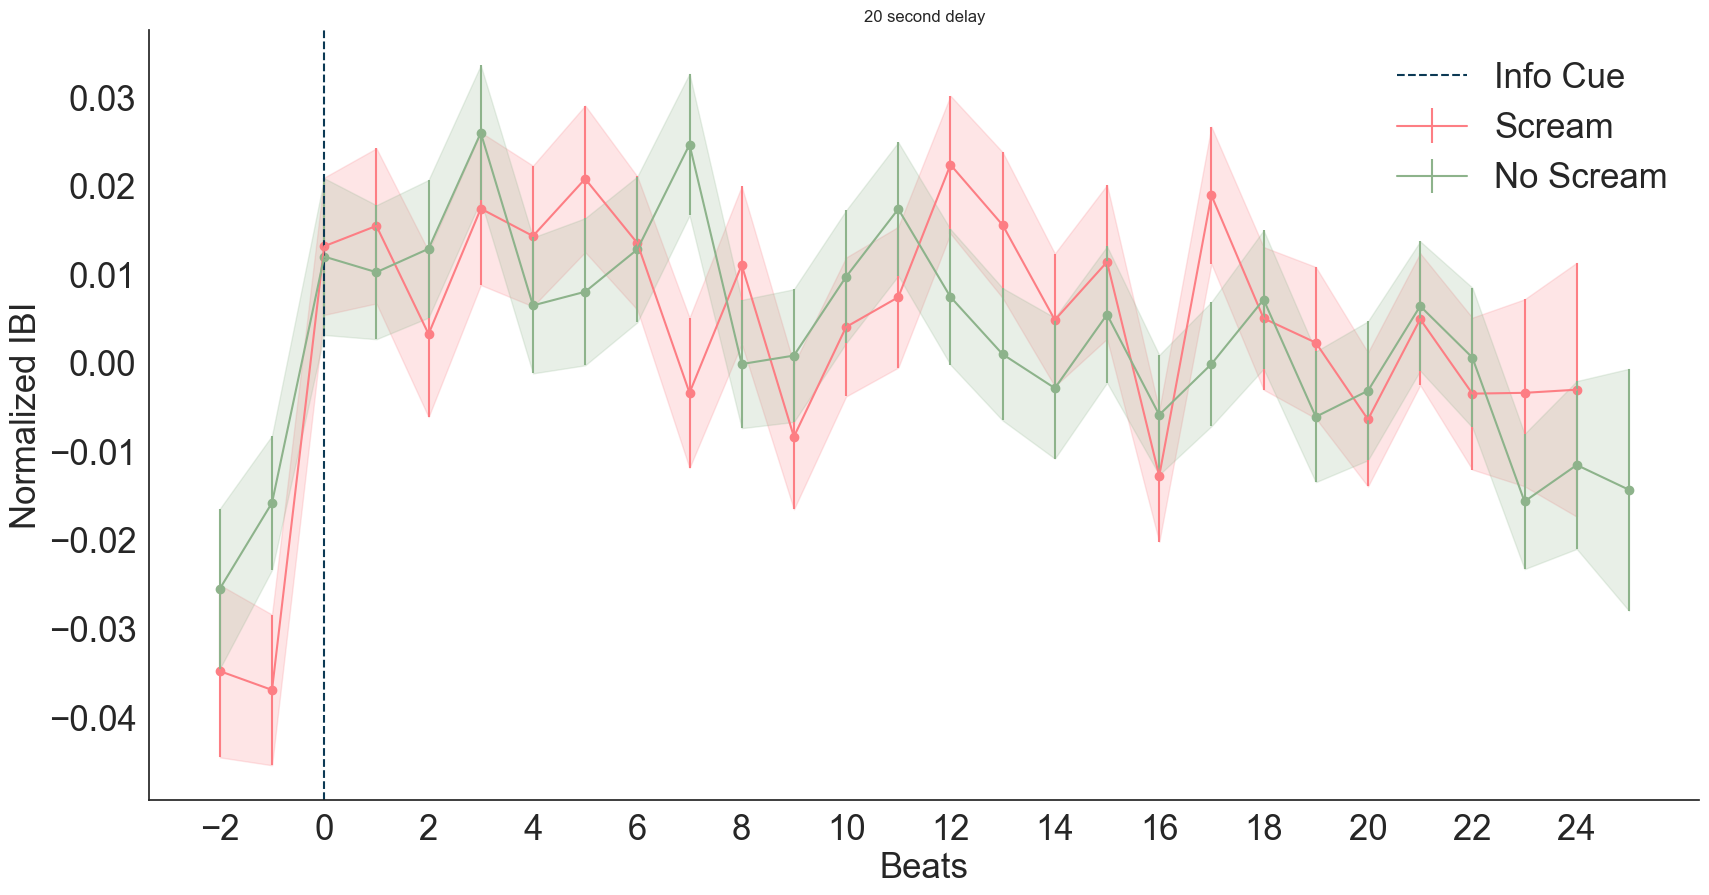

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,20)

range(-2, 52, 2)
range(-2, 53, 2)


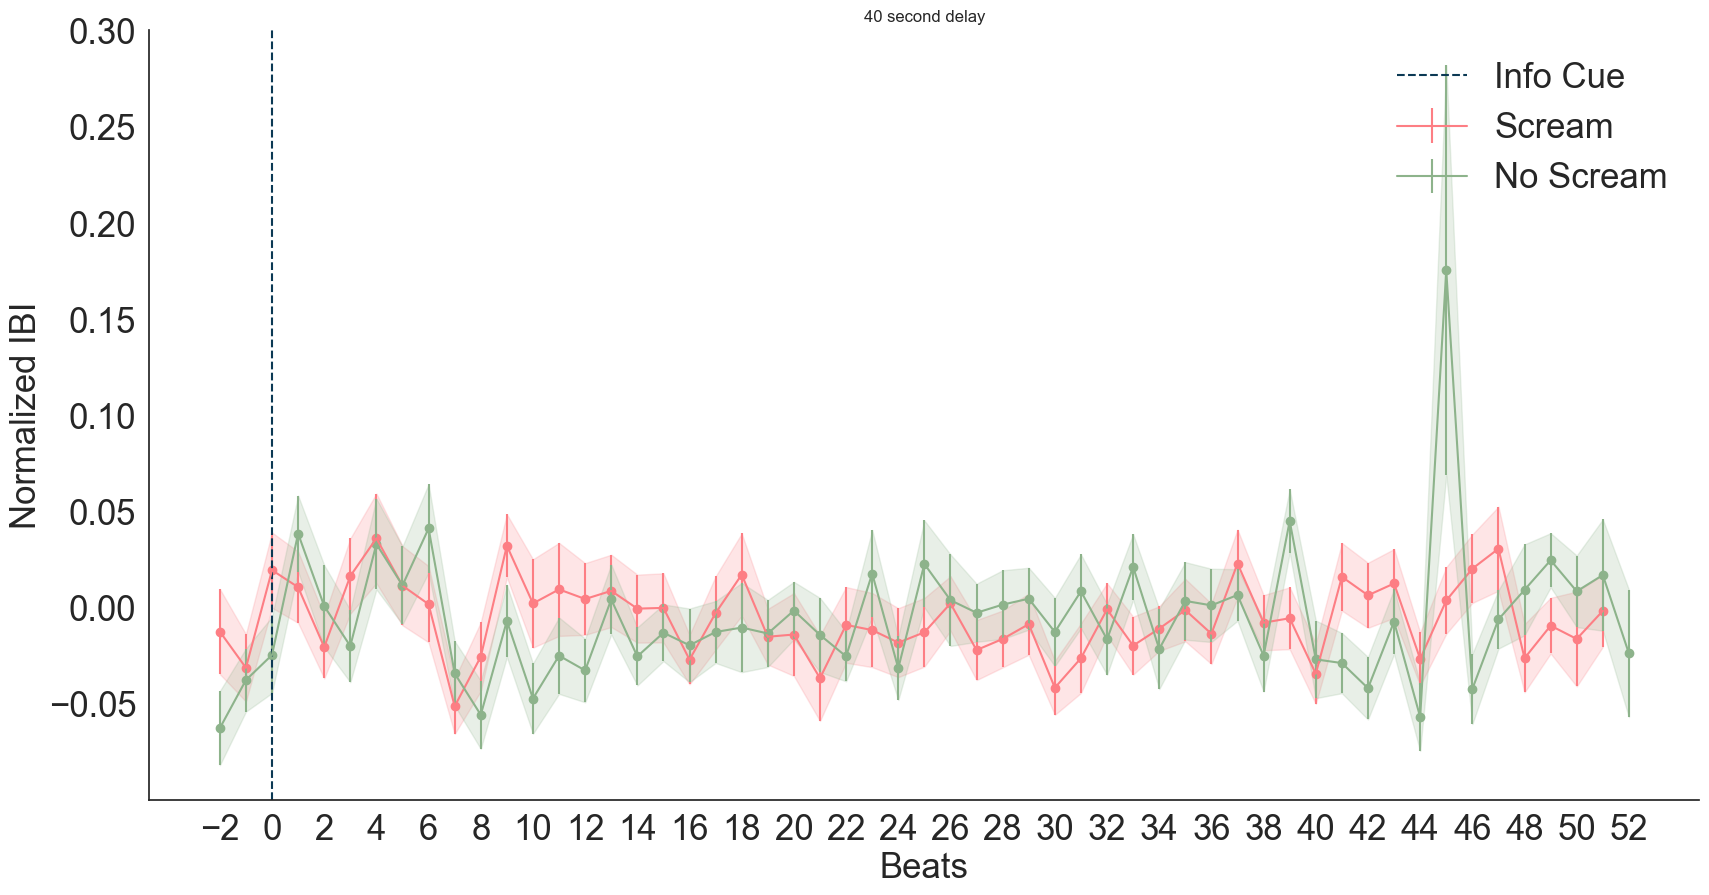

In [ ]:
plot_whole_IBI(info_scream_IBI,info_noScream_IBI,40)